<a href="https://colab.research.google.com/github/vijaygwu/MathematicsOfML/blob/main/K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Explanation of the Code**
This code implements a class-based **K-Means clustering algorithm** with support for different initialization methods, handling empty clusters, and plotting clustering results. Here's a detailed explanation, including how it leverages vectorization.

---

### **Core Features of the Class**

#### **Initialization**
- `__init__`: Sets up the parameters for the K-Means algorithm, such as the number of clusters (`n_clusters`), maximum iterations (`max_iters`), tolerance for convergence (`tol`), and initialization method (`init`).
- `_initialize_centroids`: Initializes cluster centroids using either:
  - **Random Initialization**: Randomly selects data points as initial centroids.
  - **K-Means++ Initialization**: Selects centroids to maximize initial cluster separation, reducing the chances of poor convergence.

---

#### **Fit Function**
The `fit` function is the main method for clustering data. It performs the following:

1. **Centroid Initialization**:
   - Calls `_initialize_centroids` to set up the initial centroids based on the `init` method.

2. **Iterative Optimization**:
   - **Cluster Assignment**: Each point is assigned to the nearest centroid:
     ```python
     distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
     self.labels = np.argmin(distances, axis=1)
     ```
     - **Vectorized**: Broadcasting expands `X` (shape \((n, d)\)) into a 3D array for pairwise distance calculation with centroids (shape \((k, d)\)).
     - Computes the Euclidean distance for all \(n\) points and \(k\) centroids in a single step.

   - **Centroid Update**: New centroids are calculated as the mean of all points assigned to each cluster:
     ```python
     new_centroids = np.array([
         X[self.labels == i].mean(axis=0)
         for i in range(self.n_clusters)
     ])
     ```
     - **Vectorized**: Uses array slicing (`self.labels == i`) to directly compute the mean for each cluster.

   - **Convergence Check**:
     - The algorithm stops when the centroids move less than `tol`:
       ```python
       centroid_shift = np.linalg.norm(new_centroids - self.centroids)
       ```

3. **Handling Empty Clusters**:
   - If a cluster has no assigned points, the algorithm finds the data point furthest from existing centroids and assigns it as a new centroid.

---

#### **Prediction**
The `predict` method assigns new points to the nearest centroid:
```python
distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
return np.argmin(distances, axis=1)
```
- Uses the same vectorized distance calculation as in the `fit` function.

---

#### **Visualization**
The `plot_clusters` method visualizes the clusters and centroids in 2D data:
- Displays data points with colors corresponding to their cluster labels.
- Plots centroids with a red `x`.

---

### **Vectorization in the Code**

1. **Distance Calculation**:
   - The line:
     ```python
     distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
     ```
     is a fully vectorized computation of pairwise Euclidean distances:
     - $ ( X[:, \text{np.newaxis}] \): Expands \( X \) to 3D (\(n, 1, d\)) $ for broadcasting with centroids (\(k, d\)).
     - Subtraction computes the difference between each point and each centroid.
     - `np.linalg.norm` with `axis=2` computes the \(L^2\)-norm (Euclidean distance) along the feature dimension.

2. **Cluster Mean Computation**:
   - The line:
     ```python
     new_centroids = np.array([
         X[self.labels == i].mean(axis=0)
         for i in range(self.n_clusters)
     ])
     ```
     calculates the mean for all points in a cluster in a single operation using slicing and NumPy's optimized `mean` function.

3. **Centroid Movement**:
   - The line:
     ```python
     centroid_shift = np.linalg.norm(new_centroids - self.centroids)
     ```
     efficiently computes the magnitude of centroid shifts as a vectorized operation.

---

### **K-Means++ Initialization**
The `kmeans++` method improves centroid selection:
1. The first centroid is chosen randomly.
2. Subsequent centroids are chosen probabilistically, where points farther from existing centroids have higher probabilities.
3. This step uses vectorized distance calculations to determine probabilities:
   ```python
   distances = np.min([
       np.linalg.norm(X - centroid, axis=1)**2
       for centroid in centroids
   ], axis=0)
   probabilities = distances / distances.sum()
   ```

---

### **Handling Empty Clusters**
If a cluster has no points assigned:
1. Finds the point farthest from all centroids:
   ```python
   current_distances = np.min([
       np.linalg.norm(X - cent, axis=1)**2
       for cent in new_centroids if not np.isnan(cent).any()
   ], axis=0)
   ```
2. Assigns this point as the new centroid for the empty cluster.

---

### **Main Program**
1. Generates synthetic data using `sklearn.datasets.make_blobs`.
2. Scales the data using `StandardScaler`.
3. Runs K-Means clustering and visualizes the results.

---

### **Advantages of Vectorization**
- **Speed**: Minimizes Python loops by leveraging NumPy's highly optimized operations.
- **Clarity**: Compact expressions for operations like distance calculation and cluster updates.
- **Scalability**: Handles large datasets efficiently when sufficient memory is available.

---

### **Key Outputs**
1. **Centroids**: Final cluster centers.
2. **Labels**: Cluster assignments for each data point.
3. **Inertia**: Total within-cluster sum of squared distances.
4. **Iterations**: Number of iterations to convergence.

This code provides a flexible and efficient implementation of K-Means clustering with modern features like `kmeans++` initialization and visualization.

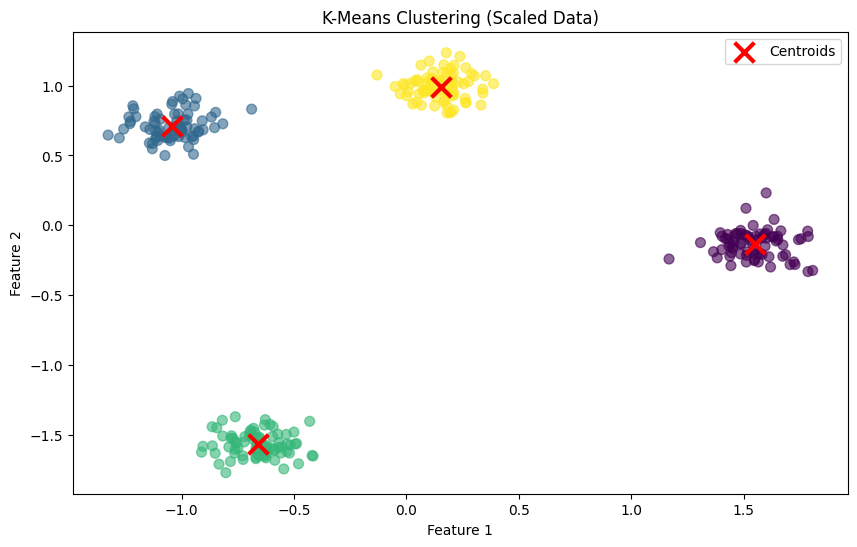

Number of iterations: 2
Final inertia: 6.42


In [2]:
import numpy as np
from typing import Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


class KMeansClustering:
    """
    A class implementing K-Means clustering with various initialization methods and visualization capabilities.

    Attributes:
        n_clusters (int): Number of clusters to form
        max_iters (int): Maximum number of iterations for the algorithm
        tol (float): Tolerance for convergence based on centroid movement
        random_state (int): Random seed for reproducibility
        centroids (ndarray): Final cluster centroids
        labels (ndarray): Cluster assignments for each data point
        inertia (float): Sum of squared distances to closest centroid
        n_iters (int): Number of iterations run
    """

    def __init__(
        self,
        n_clusters: int = 8,
        max_iters: int = 300,
        tol: float = 1e-4,
        random_state: Optional[int] = None,
        init: str = 'kmeans++'
    ):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.init = init
        self.centroids = None
        self.labels = None
        self.inertia = None
        self.n_iters = 0

    def _initialize_centroids(self, X: np.ndarray) -> np.ndarray:
        """Initialize centroids using either random or k-means++ initialization."""
        n_samples, n_features = X.shape

        if self.init == 'random':
            rng = np.random.RandomState(self.random_state)
            indices = rng.choice(n_samples, self.n_clusters, replace=False)
            return X[indices].copy()

        elif self.init == 'kmeans++':
            rng = np.random.RandomState(self.random_state)
            centroids = []

            # Choose first centroid randomly
            first_centroid = X[rng.choice(n_samples)]
            centroids.append(first_centroid)

            # Choose remaining centroids
            for _ in range(1, self.n_clusters):
                # Compute distances to existing centroids
                distances = np.min([
                    np.linalg.norm(X - centroid, axis=1)**2
                    for centroid in centroids
                ], axis=0)

                # Choose next centroid with probability proportional to distance squared
                probabilities = distances / distances.sum()
                next_centroid = X[rng.choice(n_samples, p=probabilities)]
                centroids.append(next_centroid)

            return np.array(centroids)

        else:
            raise ValueError("init must be 'random' or 'kmeans++'")

    def fit(self, X: np.ndarray) -> 'KMeansClustering':
        """
        Fit K-Means clustering to the data.

        Args:
            X: Training data of shape (n_samples, n_features)

        Returns:
            self: The fitted clustering object

        Raises:
            ValueError: If n_clusters is greater than number of samples
        """
        if self.n_clusters > X.shape[0]:
            raise ValueError(
                f"n_clusters ({self.n_clusters}) must be <= n_samples ({X.shape[0]})"
            )

        # Initialize centroids
        self.centroids = self._initialize_centroids(X)

        for iteration in range(self.max_iters):
            # Compute distances and assign clusters
            distances = np.linalg.norm(
                X[:, np.newaxis] - self.centroids, axis=2
            )
            self.labels = np.argmin(distances, axis=1)

            # Store inertia (sum of squared distances to closest centroid)
            self.inertia = np.sum(np.min(distances**2, axis=1))

            # Update centroids
            new_centroids = np.array([
                X[self.labels == i].mean(axis=0)
                for i in range(self.n_clusters)
            ])

            # Handle empty clusters
            empty_clusters = np.where(np.isnan(new_centroids).any(axis=1))[0]
            for cluster in empty_clusters:
                # Find points furthest from their centroids
                current_distances = np.min([
                    np.linalg.norm(X - cent, axis=1)**2
                    for cent in new_centroids if not np.isnan(cent).any()
                ], axis=0)
                new_centroids[cluster] = X[np.argmax(current_distances)]

            # Check for convergence
            centroid_shift = np.linalg.norm(new_centroids - self.centroids)
            self.centroids = new_centroids
            self.n_iters = iteration + 1

            if centroid_shift < self.tol:
                break

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict cluster labels for new data."""
        distances = np.linalg.norm(
            X[:, np.newaxis] - self.centroids, axis=2
        )
        return np.argmin(distances, axis=1)

    def fit_predict(self, X: np.ndarray) -> np.ndarray:
        """Fit and predict in one step."""
        return self.fit(X).predict(X)

    def plot_clusters(
        self,
        X: np.ndarray,
        title: str = "K-Means Clustering",
        show_centroids: bool = True,
        alpha: float = 0.6
    ) -> None:
        """
        Plot the clustering results for 2D data.

        Args:
            X: Data points of shape (n_samples, 2)
            title: Plot title
            show_centroids: Whether to show cluster centroids
            alpha: Transparency of points
        """
        if X.shape[1] != 2:
            raise ValueError("Data must be 2-dimensional for visualization")

        plt.figure(figsize=(10, 6))
        plt.scatter(
            X[:, 0],
            X[:, 1],
            c=self.labels,
            cmap='viridis',
            alpha=alpha,
            s=50
        )

        if show_centroids:
            plt.scatter(
                self.centroids[:, 0],
                self.centroids[:, 1],
                c='red',
                marker='x',
                s=200,
                linewidths=3,
                label='Centroids'
            )
            plt.legend()

        plt.title(title)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()


def main():
    """Example usage of KMeansClustering class."""
    # Generate sample data
    from sklearn.datasets import make_blobs
    X, _ = make_blobs(
        n_samples=300,
        centers=4,
        cluster_std=0.60,
        random_state=42
    )

    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize and fit K-Means
    kmeans = KMeansClustering(
        n_clusters=4,
        random_state=42,
        init='kmeans++'
    )
    kmeans.fit(X_scaled)

    # Plot results
    kmeans.plot_clusters(X_scaled, title="K-Means Clustering (Scaled Data)")

    print(f"Number of iterations: {kmeans.n_iters}")
    print(f"Final inertia: {kmeans.inertia:.2f}")


if __name__ == "__main__":
    main()

**Vectorized VS Non-Vectorized**



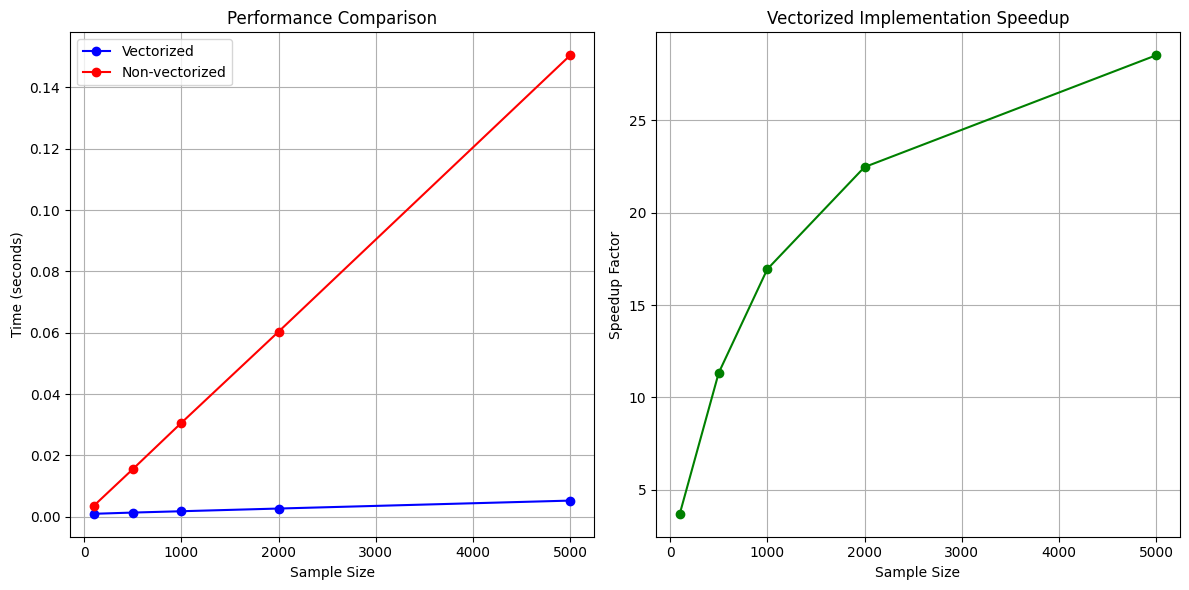

In [5]:
import numpy as np
import time
from typing import Tuple, Optional
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

class NonVectorizedKMeans:
    """Non-vectorized implementation of K-Means clustering"""

    def __init__(
        self,
        n_clusters: int = 8,
        max_iters: int = 300,
        tol: float = 1e-4,
        random_state: Optional[int] = None,
        init: str = 'kmeans++'
    ):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.init = init
        self.centroids = None
        self.labels = None
        self.inertia = None
        self.n_iters = 0

    def _initialize_centroids(self, X: np.ndarray) -> np.ndarray:
        n_samples = X.shape[0]
        rng = np.random.RandomState(self.random_state)

        if self.init == 'random':
            indices = rng.choice(n_samples, self.n_clusters, replace=False)
            return X[indices].copy()

        elif self.init == 'kmeans++':
            centroids = []
            first_centroid = X[rng.choice(n_samples)]
            centroids.append(first_centroid)

            for _ in range(1, self.n_clusters):
                distances = np.zeros(n_samples)
                for i in range(n_samples):
                    min_dist = float('inf')
                    for centroid in centroids:
                        dist = 0
                        for j in range(len(X[i])):
                            dist += (X[i][j] - centroid[j]) ** 2
                        min_dist = min(min_dist, dist)
                    distances[i] = min_dist

                probabilities = distances / distances.sum()
                next_centroid = X[rng.choice(n_samples, p=probabilities)]
                centroids.append(next_centroid)

            return np.array(centroids)

    def fit(self, X: np.ndarray) -> 'NonVectorizedKMeans':
        if self.n_clusters > X.shape[0]:
            raise ValueError(f"n_clusters ({self.n_clusters}) must be <= n_samples ({X.shape[0]})")

        self.centroids = self._initialize_centroids(X)
        n_samples, n_features = X.shape

        for iteration in range(self.max_iters):
            # Assign points to clusters
            self.labels = np.zeros(n_samples, dtype=int)
            self.inertia = 0

            for i in range(n_samples):
                min_dist = float('inf')
                closest_cluster = 0

                for j in range(self.n_clusters):
                    dist = 0
                    for k in range(n_features):
                        dist += (X[i][k] - self.centroids[j][k]) ** 2

                    if dist < min_dist:
                        min_dist = dist
                        closest_cluster = j

                self.labels[i] = closest_cluster
                self.inertia += min_dist

            # Update centroids
            new_centroids = np.zeros_like(self.centroids)
            counts = np.zeros(self.n_clusters)

            for i in range(n_samples):
                cluster = self.labels[i]
                counts[cluster] += 1
                for j in range(n_features):
                    new_centroids[cluster][j] += X[i][j]

            # Handle empty clusters and calculate means
            empty_clusters = []
            for i in range(self.n_clusters):
                if counts[i] > 0:
                    new_centroids[i] /= counts[i]
                else:
                    empty_clusters.append(i)

            # Handle empty clusters
            for cluster in empty_clusters:
                max_dist = -1
                furthest_point = None

                for i in range(n_samples):
                    dist = 0
                    assigned_centroid = new_centroids[self.labels[i]]
                    for j in range(n_features):
                        dist += (X[i][j] - assigned_centroid[j]) ** 2

                    if dist > max_dist:
                        max_dist = dist
                        furthest_point = X[i]

                new_centroids[cluster] = furthest_point

            # Check convergence
            centroid_shift = 0
            for i in range(self.n_clusters):
                for j in range(n_features):
                    centroid_shift += (new_centroids[i][j] - self.centroids[i][j]) ** 2
            centroid_shift = np.sqrt(centroid_shift)

            self.centroids = new_centroids
            self.n_iters = iteration + 1

            if centroid_shift < self.tol:
                break

        return self

def benchmark_implementations(sample_sizes=[100, 500, 1000, 2000, 5000]):
    """Benchmark both implementations with different sample sizes."""
    vectorized_times = []
    non_vectorized_times = []

    for n_samples in sample_sizes:
        # Generate data
        X, _ = make_blobs(
            n_samples=n_samples,
            centers=4,
            cluster_std=0.60,
            random_state=42
        )
        X = StandardScaler().fit_transform(X)

        # Test vectorized implementation
        kmeans_vec = KMeansClustering(n_clusters=4, random_state=42)
        start_time = time.time()
        kmeans_vec.fit(X)
        vectorized_times.append(time.time() - start_time)

        # Test non-vectorized implementation
        kmeans_nonvec = NonVectorizedKMeans(n_clusters=4, random_state=42)
        start_time = time.time()
        kmeans_nonvec.fit(X)
        non_vectorized_times.append(time.time() - start_time)

    return sample_sizes, vectorized_times, non_vectorized_times

def plot_comparison(sample_sizes, vectorized_times, non_vectorized_times):
    """Create visualization comparing the performance of both implementations."""
    plt.figure(figsize=(12, 6))

    # Plot times
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, vectorized_times, 'b-o', label='Vectorized')
    plt.plot(sample_sizes, non_vectorized_times, 'r-o', label='Non-vectorized')
    plt.xlabel('Sample Size')
    plt.ylabel('Time (seconds)')
    plt.title('Performance Comparison')
    plt.legend()
    plt.grid(True)

    # Plot speedup
    plt.subplot(1, 2, 2)
    speedup = [n/v for n, v in zip(non_vectorized_times, vectorized_times)]
    plt.plot(sample_sizes, speedup, 'g-o')
    plt.xlabel('Sample Size')
    plt.ylabel('Speedup Factor')
    plt.title('Vectorized Implementation Speedup')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run benchmark
sample_sizes, vec_times, nonvec_times = benchmark_implementations()
plot_comparison(sample_sizes, vec_times, nonvec_times)

**Results and Performance**

Left Graph (Performance Comparison):
- The blue line (Vectorized) shows the runtime of the vectorized implementation
- The red line (Non-vectorized) shows the runtime of the loop-based implementation
- As the sample size increases (x-axis), we can see that:
  * The vectorized version (blue) grows very slowly, staying under 0.02 seconds even with 5000 samples
  * The non-vectorized version (red) grows much more rapidly, reaching about 0.15 seconds with 5000 samples
  * The non-vectorized line shows a roughly quadratic growth pattern (curves upward)

Right Graph (Vectorized Implementation Speedup):
- This shows how many times faster the vectorized version is compared to the non-vectorized version
- The speedup factor increases with sample size:
  * At 100 samples: about 3.5x faster
  * At 1000 samples: about 11x faster
  * At 2000 samples: about 22x faster
  * At 5000 samples: about 28x faster

**Why the vectorized implementation performs better?**
1. The vectorized implementation is significantly more efficient due to:
   - Using NumPy's optimized array operations
   - Avoiding Python-level loops
   - Better memory access patterns
   - Potential parallel processing at the CPU level

2. The performance gap widens with larger datasets:
   - The non-vectorized version suffers from nested loops (O(n²) complexity)
   - The vectorized version better utilizes modern CPU architectures and memory hierarchies

